# IFN645 Case Study 2
## Mining from Manufacturing, Supermarket, News Stories and Web Log Data

### Contents
1. [Clustering & Pre-processing](#clust)
2. [Association Mining](#association)
3. [Text Mining](#text)
4. [Web Mining](#web)

---
## Part 1: Clustering Pre-processing and K-means analysis<a name="clust"></a>
### 1. Can you identify data quality issues in this dataset such as unusual data types, missing values, etc?
In the process of importing the data, the dataframe.info() method can be used to evaluate the dataset.

In [43]:
import pandas as pd
# Import Data from csv without skipping empty cells
df = pd.read_csv('Casestudy2-Data-Py/model_car_sales.csv', na_filter=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 8 columns):
LOCATION_NUMBER    675 non-null int64
REPORT_DATE        675 non-null object
DEALER_CODE        675 non-null object
UTE                675 non-null object
HATCH              675 non-null object
WAG0N              675 non-null object
SEDAN              675 non-null object
K__SALES_TOT       675 non-null object
dtypes: int64(1), object(7)
memory usage: 42.3+ KB


From the `info()` output, we can identify the following issues

#### Unusual Datatypes
<table>
<tr>
<th>Variable Name</th>
<th>Current Datatype</th>
<th>Desired Datatype</th>
</tr>
<tr>
<td>HATCH</td>
<td>Object</td>
<td>int64</td>
</tr>
<tr>
<td>SEDAN</td>
<td>Object</td>
<td>int64</td>
</tr>
<tr>
<td>WAGON</td>
<td>Object</td>
<td>int64</td>
</tr>
<tr>
<td>UTE</td>
<td>Object</td>
<td>int64</td>
</tr>
<tr>
<td>K_SALES_TOT </td>
<td>Object</td>
<td>int64</td>
</tr>
</table>
     
For the given data description, the fields `UTE`, `HATCH`,`SEDAN`, `WAG0N` and `K_SALES_TOT` should be interval/numerical values as opposed to objects.
By using the `.describe()` function, we may be able to uncover the source of the issues in the dataset

In [44]:
# print details for all variables in dataframe
for cols in df:
    print(df[cols].describe())
    print("-"*20)

count    675.0
mean     338.0
std      195.0
min        1.0
25%      169.5
50%      338.0
75%      506.5
max      675.0
Name: LOCATION_NUMBER, dtype: float64
--------------------
count            675
unique             1
top       2013-04-30
freq             675
Name: REPORT_DATE, dtype: object
--------------------
count          675
unique         675
top       Euro-376
freq             1
Name: DEALER_CODE, dtype: object
--------------------
count     675
unique    143
top          
freq       22
Name: UTE, dtype: object
--------------------
count     675
unique    518
top          
freq       22
Name: HATCH, dtype: object
--------------------
count     675
unique    426
top          
freq       22
Name: WAG0N, dtype: object
--------------------
count     675
unique    501
top          
freq       22
Name: SEDAN, dtype: object
--------------------
count     675
unique    109
top       932
freq       25
Name: K__SALES_TOT, dtype: object
--------------------


Analysis of the `.describe()` output show a number of unusual results which may explain the cause of the unusual data types.

For this output, `top` describes the most commonly occuring value in the dataset. For the fields `UTE`, `HATCH`, `WAG0N` and `SEDAN`, that value appears to be an empty string.

The output of the `value_counts()` function (see below) allow us to identify this as the root cause of our data abnormalities.

In [45]:
# Check for cause of issues in one of the variables
print(df['UTE'].value_counts())

       22
81     15
92     15
80     12
90     12
106    11
72     11
100    11
97     10
84     10
83     10
91      9
93      9
75      9
73      9
99      9
70      9
88      9
116     9
77      9
82      9
68      9
69      9
78      8
114     8
85      8
98      8
74      8
89      8
66      8
       ..
146     1
9       1
39      1
197     1
23      1
46      1
131     1
142     1
209     1
173     1
202     1
37      1
198     1
155     1
143     1
206     1
153     1
52      1
41      1
178     1
190     1
166     1
40      1
191     1
31      1
150     1
180     1
157     1
8       1
196     1
Name: UTE, Length: 143, dtype: int64


Additionally, we can isolate the rows containing the empty string in order to determine if there is a link between the missing variables in the data source.
By using the `.values()` or `as_matrix()` functions to gather all of the readings where UTE is equal to an empty string we ge the following output:

In [46]:
# See Rows where UTE contains empty string
print(df[df['UTE']==''].as_matrix())

[[4 '2013-04-30' 'Euro-103' '' '' '' '' '']
 [24 '2013-04-30' 'Euro-123' '' '' '' '' '']
 [50 '2013-04-30' 'Euro-149' '' '' '' '' '']
 [108 '2013-04-30' 'Euro-201' '' '' '' '' '']
 [173 '2013-04-30' 'Euro-260' '' '' '' '' '']
 [174 '2013-04-30' 'Euro-261' '' '' '' '' '']
 [175 '2013-04-30' 'Euro-262' '' '' '' '' '']
 [176 '2013-04-30' 'Euro-263' '' '' '' '' '']
 [177 '2013-04-30' 'Euro-264' '' '' '' '' '']
 [198 '2013-04-30' 'Euro-283' '' '' '' '' '']
 [199 '2013-04-30' 'Euro-284' '' '' '' '' '']
 [200 '2013-04-30' 'Euro-285' '' '' '' '' '']
 [298 '2013-04-30' 'Euro-374' '' '' '' '' '']
 [299 '2013-04-30' 'Euro-375' '' '' '' '' '']
 [300 '2013-04-30' 'Euro-376' '' '' '' '' '']
 [643 '2013-04-30' 'Euro-688' '' '' '' '' '']
 [644 '2013-04-30' 'Euro-689' '' '' '' '' '']
 [645 '2013-04-30' 'Euro-69' '' '' '' '' '']
 [646 '2013-04-30' 'Euro-70' '' '' '' '' '']
 [665 '2013-04-30' 'Euro-89' '' '' '' '' '']
 [666 '2013-04-30' 'Euro-90' '' '' '' '' '']
 [667 '2013-04-30' 'Euro-91' '' '' '' '' '

#### Missing Values
This coencides with the missing values found present in the `HATCH`,`SEDAN` and `WAG0N` fields as well, additionally identifying 22 rows where the `K_SALES_TOT` variable is also missing. A tabulated view of the results can be found below.

<table>
    <tr>
        <th>Variable Name</th>
        <th># Missing Values</th>
    </tr>
    <tr>
        <td>HATCH</td>
        <td>22</td>
    </tr>
    <tr>
        <td>SEDAN</td>
        <td>22</td>
    </tr>
    <tr>
        <td>WAGON</td>
        <td>22</td>
    </tr>
    <tr>
        <td>UTE</td>
        <td>22</td>
    </tr>
    <tr>
        <td>K_SALES_TOT</td>
        <td>22</td>
    </tr>
</table>

### 2. What variables did you include in the analysis and what were their roles and measurement level set? Justify your choice.
For our analysis of the 

---
## Part 2: Association Mining and it's data Pre-processing<a name="association"></a>

### 1. Can you identify data quality issues in this dataset for performing association mining?


In [47]:
import pandas as pd

# load the transaction dataset
df = pd.read_csv('Casestudy2-Data-Py/pos_transactions.csv')

# info and the first 10 transactions
print(df.info())
print(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459258 entries, 0 to 459257
Data columns (total 5 columns):
Location           459258 non-null int64
Transaction_Id     459258 non-null int64
Transactin_Date    459258 non-null object
Product_Name       459258 non-null object
Quantity           459258 non-null int64
dtypes: int64(3), object(2)
memory usage: 17.5+ MB
None
   Location  Transaction_Id Transactin_Date    Product_Name  Quantity
0         2           12359      2012-10-23       Candy Bar         1
1         9           12362      2012-10-23   Pain Reliever         1
2         9           12362      2012-10-23   Pain Reliever         1
3         5           12365      2012-10-23      Toothpaste         1
4         2           12371      2012-10-23             Bow         1
5         6           12380      2012-10-23  Greeting Cards         1
6         1           12383      2012-10-23   Pain Reliever         1
7         1           12383      2012-10-23   Pain Reliever        

From the first 10 transaction shown above, we can easily see that there are duplicated transactions in the dataset.
That can be seen clearly by grouping the data (see the result below)

In [48]:
df.groupby(df.columns.tolist(),as_index=False).size().sort_values(ascending = False).reset_index().rename(columns={0: 'Frequency'})

,Location,Transaction_Id,Transactin_Date,Product_Name,Quantity,Frequency
0,1,816536,2012-10-27,Magazine,1,135
1,6,79610,2012-10-24,Toothpaste,1,96
2,7,1143932,2012-10-29,Greeting Cards,1,95
3,8,205484,2012-10-24,Pain Reliever,1,83
4,8,34322,2012-10-23,Candy Bar,1,78
5,6,1014407,2012-10-28,Bow,1,75
6,10,427835,2012-10-26,Magazine,1,73
7,6,362087,2012-10-25,Candy Bar,1,72
8,7,205490,2012-10-24,Bow,1,72
9,1,1068674,2012-10-28,Magazine,1,71


The 'Frequency' column in the result above indicates the number of duplicated transactions for each unique transaction in the dataset. Therefore, we will drop those duplicated transactions except for the first occurence.

In [49]:
df = df.drop_duplicates(subset=None, keep='first', inplace=False)

As were are looking to generate association rules from items purchased by each transaction, we need to group our Transaction_Id and then generate a list of all items purchased.

In [50]:
# group by Transaction_Id, then list all items
transactions = df.groupby(['Transaction_Id'])['Product_Name'].apply(list)

print(transactions.head(10))

Transaction_Id
12359                       [Candy Bar]
12362                   [Pain Reliever]
12365                      [Toothpaste]
12371                             [Bow]
12380                  [Greeting Cards]
12383                   [Pain Reliever]
12386                   [Pain Reliever]
12392               [Shampoo, Magazine]
12401    [Candy Bar, Pencils, Magazine]
12404                       [Candy Bar]
Name: Product_Name, dtype: object


### 2. What variables did you include in the analysis and what were their roles and measurement level set? Justify your choice.
Association mining usually consists of two variables: a transaction ID and an item. Due to the main target which is to find out the associations between items purchased from the health and beauty aids department and the stationary department, the Product_Name should be chosen as the target variable and the Transaction_ID is chosen as ID. In summary, the variables included in the analysis as the below table.

<table>
    <tr>
        <th>Variable Name</th>
        <th>Role</th>
        <th>Measurement Level</th>
    </tr>
    <tr>
        <td>Product_Name</td>
        <td>Target</td>
        <td>Nominal</td>
    </tr>
    <tr>
        <td>Transaction_Id</td>
        <td>ID</td>
        <td>Nominal</td>
    </tr>
</table>

### 3. Conduct association mining and answer the following:
#### a. What is the highest lift value for the resulting rules? Which rule has this value?

Once the transactions table contains all items purchased in each transaction, we will run the apyori model with the pre-processed transactions and min_support of 0.02

In [51]:
from apyori import apriori

# type cast the transactions from pandas into normal list format and run apriori
transaction_list = list(transactions)
results = list(apriori(transaction_list, min_support=0.02))

# print first 5 rules
print(results[:5])

ModuleNotFoundError: No module named 'apyori'

In [ ]:
def convert_apriori_results_to_pandas_df(results):
    rules = []
    
    for rule_set in results:
        for rule in rule_set.ordered_statistics:
            # items_base = left side of rules, items_add = right side
            # support, confidence and lift for respective rules
            rules.append([','.join(rule.items_base), ','.join(rule.items_add),
                         rule_set.support, rule.confidence, rule.lift]) 
    
    # typecast it to pandas df
    return pd.DataFrame(rules, columns=['Left_side', 'Right_side', 'Support', 'Confidence', 'Lift']) 

result_df = convert_apriori_results_to_pandas_df(results)

print(result_df.head(20))

In order to find out the highest lift value for the resulting rules, we will sort the rules by Lift using the code below:

In [ ]:
# sort all acquired rules descending by lift# sort a 
result_df = result_df.sort_values(by='Lift', ascending=False)
print(result_df.head(10))

From the result above, the highest lift value is 3.60
There are two rules having this value: Perfume -> Toothbrush and Toothbrush -> Perfume

#### b. What is the highest confidence value for the resulting rules? Which rule has this value?

In [ ]:
In order to find out the highest confidence value for the resulting rules, we will sort the rules by Confidence using the code below:

In [ ]:
# sort all acquired rules descending by Confidence# sort a 
result_df = result_df.sort_values(by='Confidence', ascending=False)
print(result_df.head(10))

From the result above, the highest confidence value is 32.39%.
The rule has this value is Magazie & Greeding Cards -> Candy Bar  

#### c. Plot the confidence, lift, support of the resulting rules? Interpret them to discuss the rule-set obtained

### 4. The store is particularly interested in products that individuals purchase when they buy “Pens”.
#### a. How many rules are in the subset?

#### b. Based on the rules, what are the other products these individuals are most likely to purchase?

### 5. How the outcome of this study can be used by decision makers?

---
## Part 4: Web Mining<a name="web"></a>





---
## Part 3: Text Mining<a name="text"></a>





### 1. What variables did you include in the analysis and what were their roles and measurement level set? Justify your choice.

The selected column is the TEXT column, as this column contains the text data from which information will be extracted. All other columns are rejected.

The LANGUANGE, OMITTED, TRUNCATED, and EXTENSION columns are unary, and provide no meaningful data. Similarly, the URI, NAME, and FILTERED columns are incremental values that also provide no meaningful data. Finally, the columns CREATED, ACCESSED, and MODIFIED, appear to be date based values. Modified is binary, and the other columns only have thirty five unique values.

In [40]:
import pandas as pd

tf = pd.read_csv("Casestudy2-Data-Py/bbc.csv")

checkCols = ["CREATED", "ACCESSED", "MODIFIED"]

for col in checkCols:
    print(col, "- Unique:", len(tf[col].unique()))

CREATED - Unique: 35
ACCESSED - Unique: 35
MODIFIED - Unique: 2


### 2. Can you identify data quality issues in order to perform text mining?

In order to prepare the text for mining, it was first stripped of punctuation and analytically useless stopwords obtained from nltk StopWords. Secondly, the text is lemmatised using the nltk WordNet dictionary, in order to reduce words to their base format. Finally, the text is vectorised using the sklearn tf idf vectoriser, so that it can be used for clustering.

In [41]:
import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

# initialise WordNet lemmatizer and punctuation filter
lemmatizer = WordNetLemmatizer()
punct = set(string.punctuation)

stopwords = set(sw.words('english'))
stopwords.update('�')
textColumn = 'TEXT'
clusters = 7
rs = 42
docTotal = len(tf[textColumn]) #store total documents for calculating document frequency percentages

In [42]:
def lemmatize(token, tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)

    return lemmatizer.lemmatize(token, tag)

def cab_tokenizer(document):
    # initialize token list
    tokens = []
    
    # split the document into sentences
    for sent in sent_tokenize(document):
        # split the document into tokens and then create part of speech tag for each token
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # preprocess and remove unnecessary characters
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')

            # If stopword, ignore token and continue
            if token in stopwords:
                continue

            # If punctuation, ignore token and continue
            if all(char in punct for char in token):
                continue

            # Lemmatize the token and add back to the tokens list
            lemma = lemmatize(token, tag)
            tokens.append(lemma)
    
    return tokens

from sklearn.feature_extraction.text import TfidfVectorizer

# tf idf vectoriser
tfidf_vec = TfidfVectorizer(strip_accents = 'unicode', tokenizer=cab_tokenizer, ngram_range=(1,2))
X = tfidf_vec.fit_transform(tf[textColumn])
weights = tfidf_vec.idf_

# see the number of unique tokens produced by the vectorizer. Lots of them...
print("Unique tokens:", len(tfidf_vec.get_feature_names()))

Unique tokens: 36340


Without document and term frequency filtering, there are 36340 unique tokens found by the tf idf vectorizer. This is far too many to generate meaningful clusters.

In [43]:
from sklearn.cluster import KMeans

# K means clustering using the term vector
kmeans = KMeans(n_clusters=clusters, random_state=rs).fit(X)

In [44]:
# function to visualise text cluster. Useful for the assignment too :)
def visualise_text_cluster(n_clusters, cluster_centers, terms, num_word = 7):
    # -- Params --
    # cluster_centers: cluster centers of fitted/trained KMeans/other centroid-based clustering
    # terms: terms used for clustering
    # num_word: number of terms to show per cluster. Change as you please.
    
    # find features/terms closest to centroids
    ordered_centroids = cluster_centers.argsort()[:, ::-1]
    
    for cluster in range(n_clusters):
        print("Top terms for cluster {}:".format(cluster), end=" ")
        for term_idx in ordered_centroids[cluster, :num_word]:
            print(terms[term_idx], end=', ')
        print()
        
# call it
visualise_text_cluster(kmeans.n_clusters, kmeans.cluster_centers_, tfidf_vec.get_feature_names())

Top terms for cluster 0: indoor, world, record, olympic, bekele, idowu, champion, 
Top terms for cluster 1: cricket, play, say, pakistan, club, souness, want, 
Top terms for cluster 2: ball, wicket, run, strauss, australia, inning, boundary, 
Top terms for cluster 3: england, ireland, wale, nation, rugby, six nation, six, 
Top terms for cluster 4: 6, open, hewitt, win, 7, final, set, 
Top terms for cluster 5: say, cup, roddick, player, play, game, spain, 
Top terms for cluster 6: athletics, athens, drug, ban, athlete, year, marathon, 


As stated above, the clusters generated with unfiltered terms are damaged by high frequency, low value terms, such as terms like 'say', 'play', and 'ball'. These terms are vague and do not allow for meaningful conclusions to be drawn from the clusters. As such, the terms must be filtered using term/document frequency.

### 3. Based on the ZIPF plot, list the top 10 terms that will be least useful for clustering purpose.

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# creating tf-idf terms - a bit slow, do it occasionaly
def calculate_tf_idf_terms(document_col):
    # Param - document_col: collection of raw document text that you want to analyse
    from sklearn.feature_extraction.text import CountVectorizer

    # use count vectorizer to find TF and DF of each term
    count_vec = CountVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
    X_count = count_vec.fit_transform(tf[textColumn])
    
    # create list of terms and their tf and df
    terms = [{'term': t, 'idx': count_vec.vocabulary_[t],
              'tf': X_count[:, count_vec.vocabulary_[t]].sum(),
              'df': X_count[:, count_vec.vocabulary_[t]].count_nonzero(),
              'weights': weights[i]}
             for i, t in enumerate(count_vec.vocabulary_)]
    
    return terms
    
terms = calculate_tf_idf_terms(tf[textColumn])

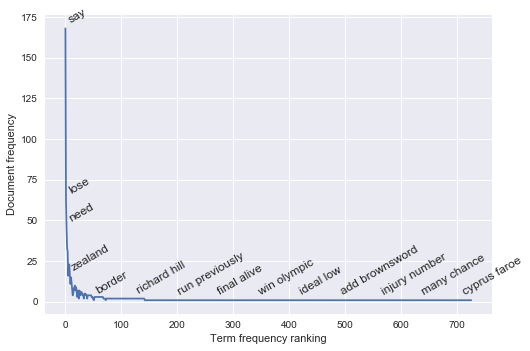

1)	Term: say 	Frequency: 447 	Weight: 5.6101577275
2)	Term: win 	Frequency: 246 	Weight: 5.6101577275
3)	Term: one 	Frequency: 204 	Weight: 5.6101577275
4)	Term: go 	Frequency: 203 	Weight: 5.6101577275
5)	Term: two 	Frequency: 197 	Weight: 5.6101577275
6)	Term: time 	Frequency: 189 	Weight: 5.6101577275
7)	Term: first 	Frequency: 185 	Weight: 5.6101577275
8)	Term: get 	Frequency: 175 	Weight: 5.6101577275
9)	Term: player 	Frequency: 164 	Weight: 5.6101577275
10)	Term: make 	Frequency: 163 	Weight: 5.6101577275


In [46]:
# visualisation of ZIPF law
def visualise_zipf(terms, itr_step = 50):
    from scipy.spatial.distance import euclidean
    from math import sqrt
    
    # --- Param ---
    # terms: collection of terms dictionary from calculate_tf_idf_terms function
    # itr_step: used to control how many terms that you want to plot. Num of terms to plot = N terms / itr_step
    
    # sort terms by its frequency
    terms.sort(key=lambda x: (x['tf'], x['df']), reverse=True)
    
    # select a few of the terms for plotting purpose
    sel_terms = [terms[i] for i in range(0, len(terms), itr_step)]
    labels = [term['term'] for term in sel_terms]
    
    # plot term frequency ranking vs its DF
    plt.plot(range(len(sel_terms)), [x['df'] for x in sel_terms])
    plt.xlabel('Term frequency ranking')
    plt.ylabel('Document frequency')
    
    max_x = len(sel_terms)
    max_y = max([x['df'] for x in sel_terms])
    
    # annotate the points
    prev_x, prev_y = 0, 0
    for label, x, y in zip(labels,range(len(sel_terms)), [x['df'] for x in sel_terms]):
        # calculate the relative distance between labels to increase visibility
        x_dist = (abs(x - prev_x) / float(max_x)) ** 2
        y_dist = (abs(y - prev_y) / float(max_y)) ** 2
        scaled_dist = sqrt(x_dist + y_dist)
        
        if (scaled_dist > 0.1):
            plt.text(x+2, y+2, label, {'ha': 'left', 'va': 'bottom'}, rotation=30)
            prev_x, prev_y = x, y
    
    plt.show()
    
    return terms

#Store terms ordered by term frequency, document frequency
orderedTerms = visualise_zipf(terms).copy()

#Reorder terms by weights
terms.sort(key=lambda x: (x['weights']), reverse=True)
for i, term in enumerate(terms[0:10]):
    print(str(i + 1) + ")\tTerm:", term['term'], "\tFrequency:", term['tf'], "\tWeight:", term['weights'])

Using ZIPF law, the least useful terms can be calculated. As visualised above, the Top 10 least useful terms by weight are:

1. say
2. win
3. one
4. go
5. two
6. time
7. first
8. get
9. player
10. make

These terms have the highest tf-idf weight values, and thus provide no meaningful value to the clustering process.

### 4. Did you disregard any frequent terms? Justify their selection.

Examining the top 25 most frequent terms from the dataset, it can be observed that there is a large amount of vague sports terminology. All of the top ten least useful terms can be observed in the top 25 most frequent. The most frequent term, 'say', also provides no value.

In [47]:
#An array of zeroes equal to the number of documents, to count document frequencies
dfCount = [0] * docTotal

for i, term in enumerate(orderedTerms):
    if i < 25:
        print(str(i + 1) + ")\tTerm:", term['term'], "\tDocument Frequency:", (term['df'] / docTotal * 100), "%\tTerm Frequency", term['tf'])
    dfCount[term['df'] - 1] += 1

1)	Term: say 	Document Frequency: 84.0 %	Term Frequency 447
2)	Term: year 	Document Frequency: 67.0 %	Term Frequency 308
3)	Term: game 	Document Frequency: 53.0 %	Term Frequency 249
4)	Term: win 	Document Frequency: 51.0 %	Term Frequency 246
5)	Term: play 	Document Frequency: 52.0 %	Term Frequency 240
6)	Term: one 	Document Frequency: 52.0 %	Term Frequency 204
7)	Term: go 	Document Frequency: 56.00000000000001 %	Term Frequency 203
8)	Term: take 	Document Frequency: 56.00000000000001 %	Term Frequency 202
9)	Term: england 	Document Frequency: 26.0 %	Term Frequency 199
10)	Term: two 	Document Frequency: 51.5 %	Term Frequency 197
11)	Term: time 	Document Frequency: 57.49999999999999 %	Term Frequency 189
12)	Term: first 	Document Frequency: 44.5 %	Term Frequency 185
13)	Term: world 	Document Frequency: 46.0 %	Term Frequency 180
14)	Term: get 	Document Frequency: 43.5 %	Term Frequency 175
15)	Term: player 	Document Frequency: 41.0 %	Term Frequency 164
16)	Term: make 	Document Frequency: 54.0

Most of the high frequency terms occur within 40-50% of the documents, except for the 9th term, 'england'. This term can be useful for clustering, and may provide useful information. All terms above 40% document frequency (appearing in over 80 documents), will be disregarded through filtering.

In [48]:
# tf idf vectoriser
tfidf_vec = TfidfVectorizer(strip_accents = 'unicode', tokenizer=cab_tokenizer, ngram_range=(1,2), min_df=1, max_df=0.4)
X = tfidf_vec.fit_transform(tf[textColumn])

# see the number of unique tokens produced by the vectorizer. Lots of them...
tokenCount = len(tfidf_vec.get_feature_names())
print("Unique tokens for 40%:", tokenCount)

kmeans = KMeans(n_clusters=clusters, random_state=rs).fit(X)
visualise_text_cluster(kmeans.n_clusters, kmeans.cluster_centers_, tfidf_vec.get_feature_names())

Unique tokens for 40%: 36320
Top terms for cluster 0: test, ball, wicket, pakistan, cricket, australia, day, 
Top terms for cluster 1: williams, wale, jones, half, scotland, italy, minute, 
Top terms for cluster 2: england, ireland, referee, wilkinson, injury, rugby, nation, 
Top terms for cluster 3: race, athens, athletics, marathon, cross country, chepkemei, paula, 
Top terms for cluster 4: open, 6, roddick, australian, australian open, hewitt, 7, 
Top terms for cluster 5: club, season, cup, team, manager, rugby, farrell, 
Top terms for cluster 6: liverpool, real, benitez, chelsea, madrid, want, club, 


Limiting the maximum document frequency to 40% removes 20 terms, which is terms 1-21, excluding 'england'.

### 5. Justify the term weighting option selected

The maximum document frequency is set to 40% to remove vague, high frequency terms, as explained above.

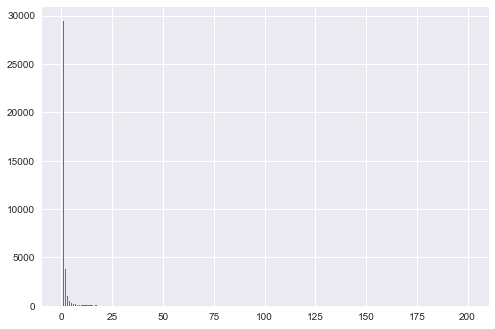

Document Frequency 1 - 5: 35101 Remainder: 1219 Elements: [29435, 3772, 1058, 523, 313]


In [49]:
#Show distribution of document frequencies.
plt.bar(range(1, len(dfCount) + 1), dfCount)
plt.show()

print("Document Frequency 1 - 5:", sum(dfCount[0:5]), "Remainder:", tokenCount - sum(dfCount[0:5]),  "Elements:", dfCount[0:5])

There are 35101 tokens that only appear in 5 or less documents, and over 29435 only appear in 1. Due to this large portion, filtering a higher minimum document frequency may remove too many terms.

In [50]:
# tf idf vectoriser
tfidf_vec = TfidfVectorizer(strip_accents = 'unicode', tokenizer=cab_tokenizer, ngram_range=(1,2), min_df=2, max_df=0.4)
X = tfidf_vec.fit_transform(tf[textColumn])

# see the number of unique tokens produced by the vectorizer. Lots of them...
tokenCount = len(tfidf_vec.get_feature_names())
print("Unique tokens for min_df = 2:", tokenCount)

kmeans = KMeans(n_clusters=clusters, random_state=rs).fit(X)
visualise_text_cluster(kmeans.n_clusters, kmeans.cluster_centers_, tfidf_vec.get_feature_names())

print()
# tf idf vectoriser
tfidf_vec = TfidfVectorizer(strip_accents = 'unicode', tokenizer=cab_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.4)
X = tfidf_vec.fit_transform(tf[textColumn])

# see the number of unique tokens produced by the vectorizer. Lots of them...
tokenCount = len(tfidf_vec.get_feature_names())
print("Unique tokens for min_df = 3:", tokenCount)

kmeans = KMeans(n_clusters=clusters, random_state=rs).fit(X)
visualise_text_cluster(kmeans.n_clusters, kmeans.cluster_centers_, tfidf_vec.get_feature_names())

print()
# tf idf vectoriser
tfidf_vec = TfidfVectorizer(strip_accents = 'unicode', tokenizer=cab_tokenizer, ngram_range=(1,2), min_df=4, max_df=0.4)
X = tfidf_vec.fit_transform(tf[textColumn])

# see the number of unique tokens produced by the vectorizer. Lots of them...
tokenCount = len(tfidf_vec.get_feature_names())
print("Unique tokens for min_df = 4:", tokenCount)

kmeans = KMeans(n_clusters=clusters, random_state=rs).fit(X)
visualise_text_cluster(kmeans.n_clusters, kmeans.cluster_centers_, tfidf_vec.get_feature_names())

print()
# tf idf vectoriser
tfidf_vec = TfidfVectorizer(strip_accents = 'unicode', tokenizer=cab_tokenizer, ngram_range=(1,2), min_df=5, max_df=0.4)
X = tfidf_vec.fit_transform(tf[textColumn])

# see the number of unique tokens produced by the vectorizer. Lots of them...
tokenCount = len(tfidf_vec.get_feature_names())
print("Unique tokens for min_df = 5:", tokenCount)

kmeans = KMeans(n_clusters=clusters, random_state=rs).fit(X)
visualise_text_cluster(kmeans.n_clusters, kmeans.cluster_centers_, tfidf_vec.get_feature_names())

Unique tokens for min_df = 2: 6885
Top terms for cluster 0: england, cricket, ball, south, pakistan, test, day, 
Top terms for cluster 1: 6, roddick, 7, 3, set, moya, nadal, 
Top terms for cluster 2: open, australian, grand slam, slam, wale, australian open, grand, 
Top terms for cluster 3: club, manager, want, beckham, real, league, deal, 
Top terms for cluster 4: race, indoor, olympic, marathon, athens, record, cross country, 
Top terms for cluster 5: drug, ban, greek, iaaf, test, kenteris, athlete, 
Top terms for cluster 6: liverpool, chelsea, arsenal, benitez, ferguson, gerrard, shot, 

Unique tokens for min_df = 3: 3113
Top terms for cluster 0: arsenal, chelsea, henry, ferguson, wenger, beckham, team, 
Top terms for cluster 1: race, athletics, athens, olympic, indoor, medal, record, 
Top terms for cluster 2: england, wale, ireland, nation, six nation, six, scotland, 
Top terms for cluster 3: 6, roddick, cup, 7, spain, moya, davis cup, 
Top terms for cluster 4: cricket, england, pa

Examining the clusters generated at different min_df levels, setting the minimum document frequency to 4 produces the best results. Meaningful clusters are generated such as the cricket tests for cluster 0, and athletics bans for cluster 4.

### 6. What is the number of input features available to execute clustering?  (For information: Note how the original text data is now converted into a feature set that can be mined for knowledge discovery?)

To reduce the tfidf frequency matrix, Singular Value Decomposition was used. By setting the number of components to 100, a significantly smaller matrix is created.

In [51]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, random_state=rs)
X_trans = svd.fit_transform(X)

# sort the components by largest weighted word
sorted_comp = svd.components_.argsort()[:, ::-1]
terms = tfidf_vec.get_feature_names()

# visualise word - concept/component relationships
for comp_num in range(10):
    print("Top terms in component #{}".format(comp_num), end=" ")
    for i in sorted_comp[comp_num, :5]:
        print(terms[i], end=", ")
    print()

Top terms in component #0 england, open, 6, club, team, 
Top terms in component #1 6, open, 7, roddick, australian, 
Top terms in component #2 england, ball, wicket, south, australia, 
Top terms in component #3 test, athens, ban, athletics, drug, 
Top terms in component #4 ireland, wale, nation, six nation, scotland, 
Top terms in component #5 6, indoor, arsenal, 7, record, 
Top terms in component #6 drug, greek, kenteris, iaaf, ban, 
Top terms in component #7 roddick, moya, cup, davis, davis cup, 
Top terms in component #8 chepkemei, cross country, marathon, radcliffe, country, 
Top terms in component #9 liverpool, pakistan, 6, shane, club, 


In [52]:
# K-means clustering using LSA-transformed X
svd_kmeans = KMeans(n_clusters=7, random_state=rs).fit(X_trans)

# transform cluster centers back to original feature space for visualisation
original_space_centroids = svd.inverse_transform(svd_kmeans.cluster_centers_)

# visualisation
visualise_text_cluster(svd_kmeans.n_clusters, original_space_centroids, tfidf_vec.get_feature_names(), num_word = 15)

Top terms for cluster 0: open, 6, australian, australian open, hewitt, 7, federer, match, grand slam, final, wimbledon, slam, grand, roddick, safin, 
Top terms for cluster 1: ireland, england, wale, nation, six nation, scotland, six, italy, half, france, williams, side, try, hodgson, wing, 
Top terms for cluster 2: club, rugby, england, cup, bath, director, coach, new, sri, team, celtic, want, season, zealand, new zealand, 
Top terms for cluster 3: athens, olympic, race, athletics, indoor, medal, record, athlete, drug, ban, marathon, champion, chepkemei, paula, european, 
Top terms for cluster 4: cricket, pakistan, ball, test, wicket, day, england, south, series, africa, south africa, vaughan, australia, india, run, 
Top terms for cluster 5: chelsea, arsenal, liverpool, club, newcastle, want, real, ferguson, manager, bos, league, manchester, souness, madrid, city, 
Top terms for cluster 6: moya, davis cup, davis, roddick, spain, cup, nadal, clay, seville, 6, beat, 7, carlos, single, vi

### 7. State how many clusters are generated? Name each cluster meaningfully according to the terms that appear in the clusters?

There were seven clusters generated through singular value decomposition. These clusters each had meaningful categories and themes.

Cluster 1: Australian Open Tennis

Containing terms such as Hewitt, Federer, Australian Open and Grand Slam, this cluster is about professional tennis.

Cluster 2: Six Nation Rugby Union
      
Featuring the term 'Six Nation' and the six nations that competed in the tournament, 'Ireland', 'England', 'Wales', 'Scotland', 'Italy' and 'France', this cluster focuses on the annual Six Nationa Rugby Union competition     
        
Cluster 3: Rugby Team Changes

This cluster is about changes in staff and players in rugby teams. This is evidenced by the terms 'rugby', 'club', 'director', 'coach', 'new' and 'want'

Cluster 4: Athletics Drug Bans

With the terms 'Athens', 'Olympic', 'athletics', 'drug' and 'ban', this cluster is about drug related bans occurring at the Athens Olympics.

Cluster 5: Cricket Tests

Featuring cricketing nations such as 'Pakistan', 'Australia', 'South Africa' and 'India', as well as the terms 'cricket', 'test', 'wicket' and 'run'. This section is about cricket test matches between nations.

Cluster 6: European Football

Naming several prominent European Football clubs, 'Chelsea', 'Arsenal', 'Liverpool' and 'Manchester', this section is about the European Football League

Cluster 7: Davis Cup Tennis

The final cluster is about the Davis Cup in tennis. This can be shown by the terms 'Davis Cup' and the names of famous professional tennis players such as 'Roddick', 'Nadal' and 'Moya'.

### 8. Identify the first fifteen high frequent terms (that are not stop words or noise) in the start list?

To find the first fifteen most frequent terms, the remaining terms used in the singular value decomposition are extracted from the complete list of terms ordered by term frequency, created in question 4.

In [ ]:
svdTerms = []
for term in orderedTerms:
    if term['term'] in tfidf_vec.get_feature_names():
        svdTerms.append(term)

In [60]:
for i, term in enumerate(svdTerms[0:40]):
    print(str(i + 1) + ")\tTerm:", term['term'], "\tFrequency:", term['tf'])

1)	Term: england 	Frequency: 199
2)	Term: team 	Frequency: 144
3)	Term: match 	Frequency: 133
4)	Term: second 	Frequency: 132
5)	Term: set 	Frequency: 131
6)	Term: 6 	Frequency: 130
7)	Term: give 	Frequency: 126
8)	Term: day 	Frequency: 126
9)	Term: open 	Frequency: 126
10)	Term: final 	Frequency: 120
11)	Term: new 	Frequency: 116
12)	Term: want 	Frequency: 113
13)	Term: three 	Frequency: 112
14)	Term: cup 	Frequency: 111
15)	Term: good 	Frequency: 110
16)	Term: think 	Frequency: 110
17)	Term: u 	Frequency: 109
18)	Term: club 	Frequency: 109
19)	Term: four 	Frequency: 107
20)	Term: run 	Frequency: 106
21)	Term: injury 	Frequency: 105
22)	Term: roddick 	Frequency: 104
23)	Term: champion 	Frequency: 103
24)	Term: test 	Frequency: 99
25)	Term: point 	Frequency: 97
26)	Term: end 	Frequency: 96
27)	Term: ball 	Frequency: 96
28)	Term: well 	Frequency: 93
29)	Term: season 	Frequency: 93
30)	Term: side 	Frequency: 93
31)	Term: lose 	Frequency: 92
32)	Term: like 	Frequency: 92
33)	Term: half 	F

The top fifteen terms are:

1. England
2. Team
3. Match
4. Second
5. Set
6. Give
7. Day
8. Open
9. Final
10. New
11. Want
12. Cup
13. Good
14. Think
15. Club




### 9. Describe how these clusters can be useful in the online personalised news story service planned.

From the clusters discerned in this section, there are several observations that can be made. However, the news articles focus primarily on sport. This may be a result of a biased sample, choosing only sports related articles, but this does not mean the observations are invalid. Instead, these observations can be applied specifically to sports journalism.

Firstly, the clusters seem to be evenly split between different sports. Cricket, tennis, rugby union, football (soccer), and athletics are represented. This implies an even coverage of popular sports is necessary. There may be available audiences for each discipline, and focusing too hard on a singular sport will shrink the audience.

Secondly, the clusters focus on the 'highest' levels of the sport. The Australian Open and Davis Cup for tennis, the international tests for cricket, and the European football leagues. The implication is that there is the most interest around the highest levels and greatest competitions of the sport.

Finally, there are also clusters relating to background machinations and controversy. For example, the drug bans in the Athens Olympics and the potential new managers in European Football. This ties in to the second point, as audiences are most likely interested in the events that can affect the outcomes of their sports championships and tournaments.